### Import Library


In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
import os

### Set Path Dataset


In [3]:
base_dir = "D:/laskarAI/ml-terrascan/dataset_split"
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")

img_height = 224
img_width = 224
batch_size = 32

### Load Dataset


In [4]:
train_ds = image_dataset_from_directory(
    train_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True
)

val_ds = image_dataset_from_directory(
    test_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True
)

class_names = train_ds.class_names
num_classes = len(class_names)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

Found 128 files belonging to 8 classes.


Found 32 files belonging to 8 classes.


### Augmentasi & Preprocessing


In [5]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

preprocess_input = tf.keras.applications.efficientnet.preprocess_input

### Bangun Model


In [6]:
base_model = tf.keras.applications.EfficientNetB0(
    input_shape=(img_height, img_width, 3),
    include_top=False,
    weights='imagenet'
)

# Fine-tuning sebagian layer
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False

# Arsitektur model lengkap
inputs = tf.keras.Input(shape=(img_height, img_width, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model = models.Model(inputs, outputs)

### Compile and Train


In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-5)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.0938 - loss: 2.1551 - val_accuracy: 0.1562 - val_loss: 2.0839 - learning_rate: 1.0000e-04
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.3104 - loss: 1.9581 - val_accuracy: 0.3125 - val_loss: 1.9449 - learning_rate: 1.0000e-04
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.3594 - loss: 1.7954 - val_accuracy: 0.3750 - val_loss: 1.8237 - learning_rate: 1.0000e-04
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.4958 - loss: 1.6761 - val_accuracy: 0.3750 - val_loss: 1.7157 - learning_rate: 1.0000e-04
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.5875 - loss: 1.5193 - val_accuracy: 0.4375 - val_loss: 1.6195 - learning_rate: 1.0000e-04
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.6156 - loss: 1.4158 - val_accuracy: 0.5312 - val_loss: 1.5362 - learning_rate: 1.0000e-04
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.7333 - loss: 1.2789 - val_accura

### Visualisasi Akurasi


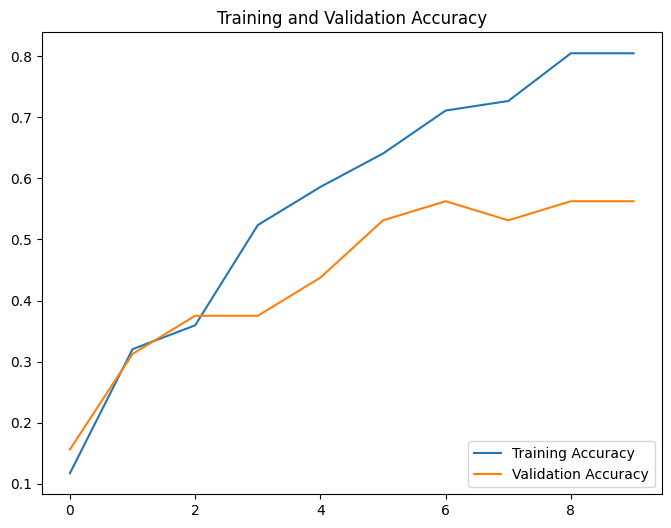

In [8]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs_range = range(len(acc))

plt.figure(figsize=(8, 6))
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()

### Save Model


In [9]:
model.save("D:/laskarAI/ml-terrascan/model_terrascan.keras")
print("✅ Model saved as model_terrascan.keras")

✅ Model saved as model_terrascan.keras
